<a href="https://colab.research.google.com/github/i-am-parker01/Stock-price-Predictor-using-GRU-Gated-Recurrent-Unit-/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --quiet

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout


#--->>>> STEP 2: Download Stock Data

# Example: Tesla (TSLA), last 5 years


In [4]:
ticker = "TSLA"
data = yf.download(ticker, start="2018-01-01", end="2023-12-31")

print(data.head())

/tmp/ipython-input-1344937757.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2018-01-02  21.368668  21.474001  20.733334  20.799999   65283000
2018-01-03  21.150000  21.683332  21.036667  21.400000   67822500
2018-01-04  20.974667  21.236668  20.378668  20.858000  149194500
2018-01-05  21.105333  21.149332  20.799999  21.108000   68868000
2018-01-08  22.427334  22.468000  21.033333  21.066668  147891000



# -->>>STEP 3: Preprocess Data

# We'll use only the "Close" price

In [5]:
close_prices = data['Close'].values.reshape(-1, 1)

In [6]:
# Normalizing values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [7]:
# Creating sequences: using 60 past days to predict the next day
sequence_length = 60

In [8]:
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

In [9]:
# Reshape for GRU [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [10]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1449, 60, 1)
Shape of y: (1449,)


In [11]:
# Train/Test splitting(80% training , 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


#--->>>>>> STEP 4: Building the GRU (Gated Recurrent Unit) Model


In [12]:
model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,601 (357.82 KB)

 Trainable params: 91,601 (357.82 KB)

 Non-trainable params: 0 (0.00 B)


# =>>>> STEP 5: Training the  Model


In [14]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 0.0387 - val_loss: 0.0013
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0022 - val_loss: 7.6364e-04
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0021 - val_loss: 6.8626e-04
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0019 - val_loss: 6.7828e-04
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0016 - val_loss: 6.3295e-04
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0015 - val_loss: 5.9074e-04
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0014 - val_loss: 5.7858e-04
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0015 - val_loss: 9.1711e-04
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0017 - val_loss: 8.8549e-04
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0013 - val_loss: 5.1955e-04
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0013 - val_loss: 5.2780e-04
Epoch 12/20


=>>>> STEP 6: Evaluating the Model

In [15]:
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [16]:
# Inverse scaling to get actual prices
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

In [18]:
# Metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print("RMSE is :", rmse)
print("MAE is :", mae)

RMSE is : 8.387510735724543
MAE is : 6.5696300901215645


=>>>>> STEP 7: Visualization

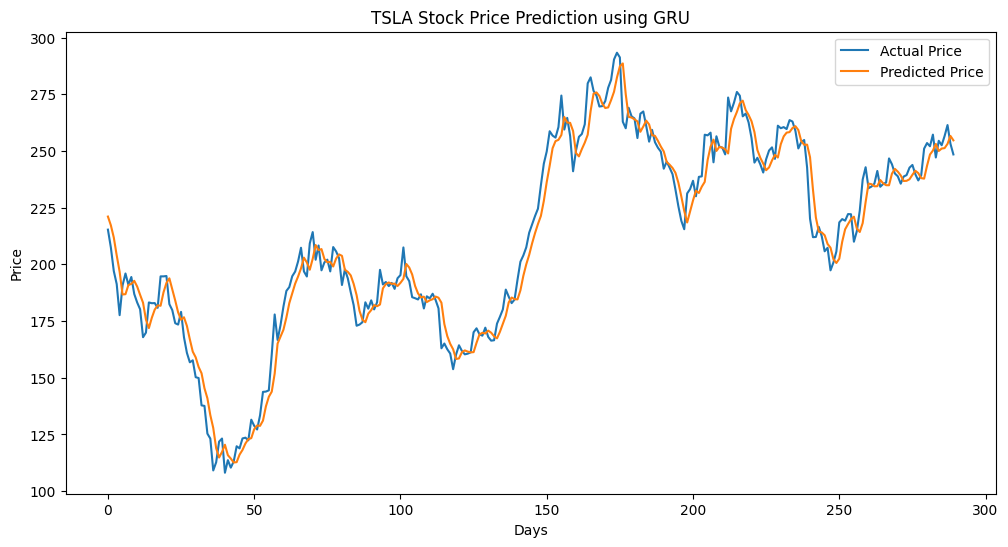

In [19]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual Price")
plt.plot(y_pred_rescaled, label="Predicted Price")
plt.title(f"{ticker} Stock Price Prediction using GRU")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


/tmp/ipython-input-3895057191.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download("TSLA", start="2024-01-01", end="2024-09-01")
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Test on 2024 Data -> RMSE: 9.012764905413814
Test on 2024 Data -> MAE: 6.507905465585213


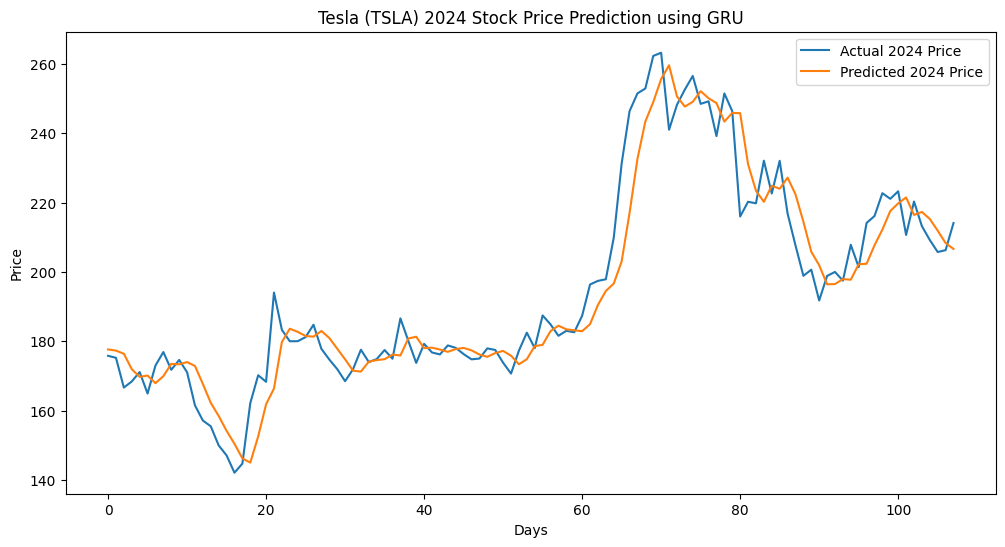

In [20]:
# STEP 8: Testing the model on NEW Unseen Data of (2024)
# Download test data (2024 Tesla stock prices)
test_data = yf.download("TSLA", start="2024-01-01", end="2024-09-01")

# Using the same scaler (fit from training data)
actual_prices = test_data['Close'].values.reshape(-1, 1)
scaled_test_data = scaler.transform(actual_prices)

# Creating sequences (same length as training= 60 days)
X_new, y_new = [], []
for i in range(sequence_length, len(scaled_test_data)):
    X_new.append(scaled_test_data[i-sequence_length:i, 0])
    y_new.append(scaled_test_data[i, 0])

X_new, y_new = np.array(X_new), np.array(y_new)
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))

# Predictions
y_new_pred = model.predict(X_new)

# Inverse scaling
y_new_rescaled = scaler.inverse_transform(y_new.reshape(-1, 1))
y_new_pred_rescaled = scaler.inverse_transform(y_new_pred)

# Evaluating the model:
rmse_new = np.sqrt(mean_squared_error(y_new_rescaled, y_new_pred_rescaled))
mae_new = mean_absolute_error(y_new_rescaled, y_new_pred_rescaled)
print("Test on 2024 Data -> RMSE:", rmse_new)
print("Test on 2024 Data -> MAE:", mae_new)

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_new_rescaled, label="Actual 2024 Price")
plt.plot(y_new_pred_rescaled, label="Predicted 2024 Price")
plt.title("Tesla (TSLA) 2024 Stock Price Prediction using GRU")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


In [21]:
import datetime

# Today's date
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# Fetch 2024+ test data dynamically
test_data = yf.download("TSLA", start="2024-01-01", end=end_date)


/tmp/ipython-input-1598046271.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download("TSLA", start="2024-01-01", end=end_date)
[*********************100%***********************]  1 of 1 completed


X shape: (1443, 60, 1)
y shape: (1443, 7)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,207 (360.18 KB)

 Trainable params: 92,207 (360.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - loss: 0.0787 - val_loss: 0.0032
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step

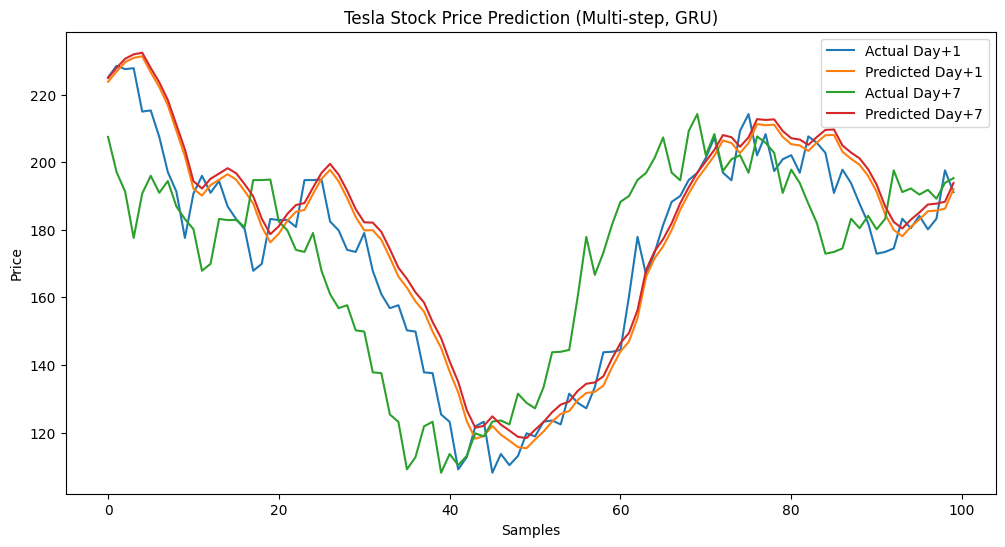

In [22]:
#->>>>> STEP 1: Prepare Data for Multi-Step Forecasting
sequence_length = 60   # use past 60 days
forecast_horizon = 7   # predict next 7 days

X, y = [], []
for i in range(sequence_length, len(scaled_data) - forecast_horizon + 1):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i:i+forecast_horizon, 0])  # 7 outputs

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("X shape:", X.shape)   # (samples, 60, 1)
print("y shape:", y.shape)   # (samples, 7)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# ---->>>>>>>>>> STEP 2: Build GRU Model for Multi-Step Prediction
model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=100))
model.add(Dropout(0.2))
model.add(Dense(forecast_horizon))  # 7 outputs instead of 1

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

#--->> STEP 3: Training the Model

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# STEP 4: Evaluating the Model

y_pred = model.predict(X_test)

# Inverse transform
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Metrics (per horizon)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print("Multi-step RMSE:", rmse)
print("Multi-step MAE:", mae)

#---->>>>>>>> STEP 5: Visualization
plt.figure(figsize=(12,6))

# Plot a slice of predictions vs actual (first 100 samples)
plt.plot(y_test_rescaled[:100, 0], label="Actual Day+1")
plt.plot(y_pred_rescaled[:100, 0], label="Predicted Day+1")

plt.plot(y_test_rescaled[:100, -1], label="Actual Day+7")
plt.plot(y_pred_rescaled[:100, -1], label="Predicted Day+7")

plt.title("Tesla Stock Price Prediction (Multi-step, GRU)")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.show()


In [24]:
#  Test on NEW Unseen Data (2024)

import datetime

# Get today's date
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# Download 2024 data (Tesla in this example)
test_data = yf.download("TSLA", start="2024-01-01", end=end_date)

print("Test data shape:", test_data.shape)
print(test_data.head())

# Extract closing prices
actual_prices = test_data['Close'].values.reshape(-1, 1)

# Scale with the SAME scaler used for training
scaled_test_data = scaler.transform(actual_prices)

# STEP A: Prepare Test Set for Single-Step Model

X_test_single, y_test_single = [], []
for i in range(sequence_length, len(scaled_test_data)):
    X_test_single.append(scaled_test_data[i-sequence_length:i, 0])
    y_test_single.append(scaled_test_data[i, 0])

X_test_single = np.array(X_test_single)
y_test_single = np.array(y_test_single)
X_test_single = np.reshape(X_test_single, (X_test_single.shape[0], X_test_single.shape[1], 1))

print("Single-step test shape:", X_test_single.shape, y_test_single.shape)

#  Prepare Test Set for Multi-Step Model (7-day)

X_test_multi, y_test_multi = [], []
for i in range(sequence_length, len(scaled_test_data) - forecast_horizon + 1):
    X_test_multi.append(scaled_test_data[i-sequence_length:i, 0])
    y_test_multi.append(scaled_test_data[i:i+forecast_horizon, 0])

X_test_multi = np.array(X_test_multi)
y_test_multi = np.array(y_test_multi)
X_test_multi = np.reshape(X_test_multi, (X_test_multi.shape[0], X_test_multi.shape[1], 1))

print("Multi-step test shape:", X_test_multi.shape, y_test_multi.shape)


/tmp/ipython-input-2602501594.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download("TSLA", start="2024-01-01", end=end_date)
[*********************100%***********************]  1 of 1 completed

Test data shape: (428, 5)
Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2024-01-02  248.419998  251.250000  244.410004  250.080002  104654200
2024-01-03  238.449997  245.679993  236.320007  244.979996  121082600
2024-01-04  237.929993  242.699997  237.729996  239.250000  102629300
2024-01-05  237.490005  240.119995  234.899994  236.860001   92488900
2024-01-08  240.449997  241.250000  235.300003  236.139999   85166600
Single-step test shape: (368, 60, 1) (368,)
Multi-step test shape: (362, 60, 1) (362, 7)
